In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time
import datetime

In [3]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Paths
images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms"
labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)
augmented_images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented"
augmented_labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented"
augmented_images, augmented_labels = load_dataset(augmented_images_dir, augmented_labels_dir)


In [ ]:
augmented_images.shape

(12490, 224, 224, 3)

: 

In [6]:
# Shuffle the augmented data
augmented_images, augmented_labels = sklearn.utils.shuffle(augmented_images, augmented_labels, random_state=42)

# Fraction of augmented data to include
fraction_to_include = 0.5

# Randomly sample 50% of the augmented dataset
num_augmented_samples = int(len(augmented_images) * fraction_to_include)
selected_indices = np.random.choice(len(augmented_images), num_augmented_samples, replace=False)

# Select the sampled augmented data and labels
selected_augmented_images = augmented_images[selected_indices]
selected_augmented_labels = augmented_labels[selected_indices]

# Combine original and sampled augmented data
merged_images = np.concatenate([images, selected_augmented_images], axis=0)
merged_labels = np.concatenate([labels, selected_augmented_labels], axis=0)

# Shuffle the merged dataset
merged_images, merged_labels = sklearn.utils.shuffle(merged_images, merged_labels, random_state=42)

# Print the sizes of the merged datasets
print(f"Total images: {merged_images.shape[0]}")
print(f"Total labels: {merged_labels.shape[0]}")

: 

: 

In [9]:
# Shuffle the training data
images, labels = sklearn.utils.shuffle(images, labels, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


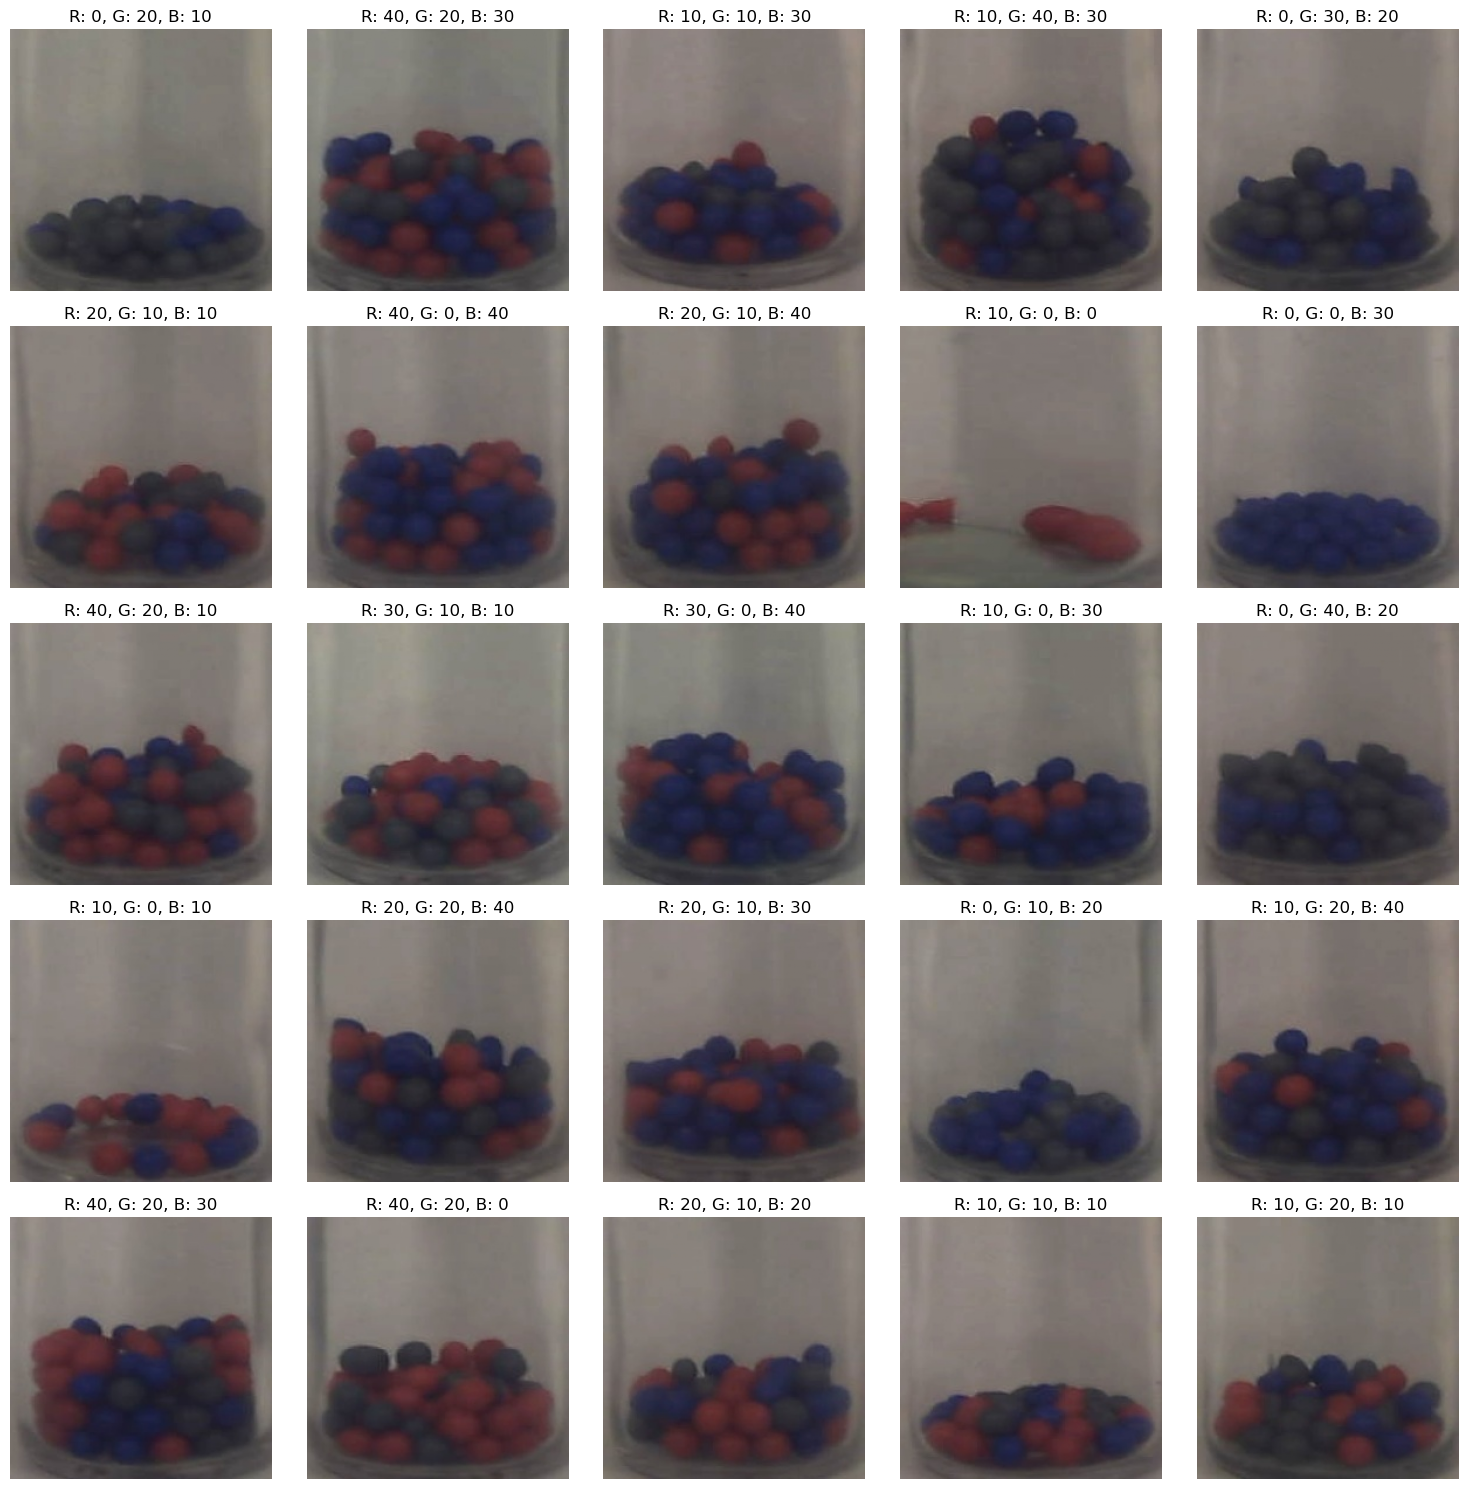

In [10]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [40]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='linear')
])(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
# model.summary()

In [41]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.02,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=True,
    fill_mode='nearest'
)

# Augment the training data
datagen.fit(X_train)

In [42]:
# Training the model for 10 epochs

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 329ms/step - loss: 377.8009 - mae: 15.8682 - val_loss: 208.8881 - val_mae: 12.5852
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 256.9057 - mae: 13.5075 - val_loss: 205.8699 - val_mae: 12.4767
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - loss: 247.4175 - mae: 13.3377 - val_loss: 212.4848 - val_mae: 12.7051
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 238.3692 - mae: 13.1026 - val_loss: 211.6962 - val_mae: 12.6850
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - loss: 237.1993 - mae: 13.0910 - val_loss: 208.1311 - val_mae: 12.5661
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 234.7597 - mae: 13.0484 - val_loss: 203.7339 - val_mae: 12.3784
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 235.6223 - mae: 13.0506 - val_loss: 205.5854 - val_mae: 12.4708
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 233.9386 - mae: 13.1016 - val_loss: 201.5355 - val_mae: 12.1961


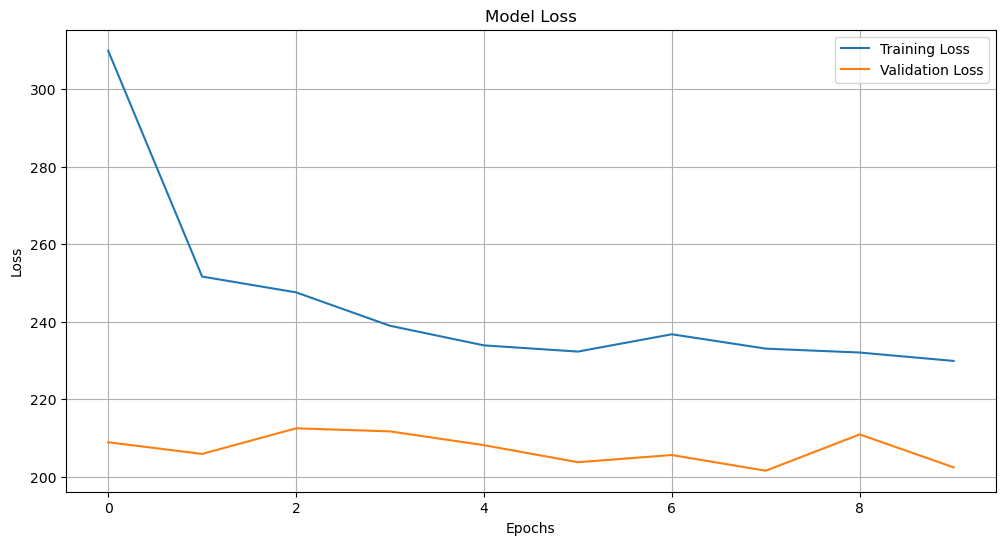

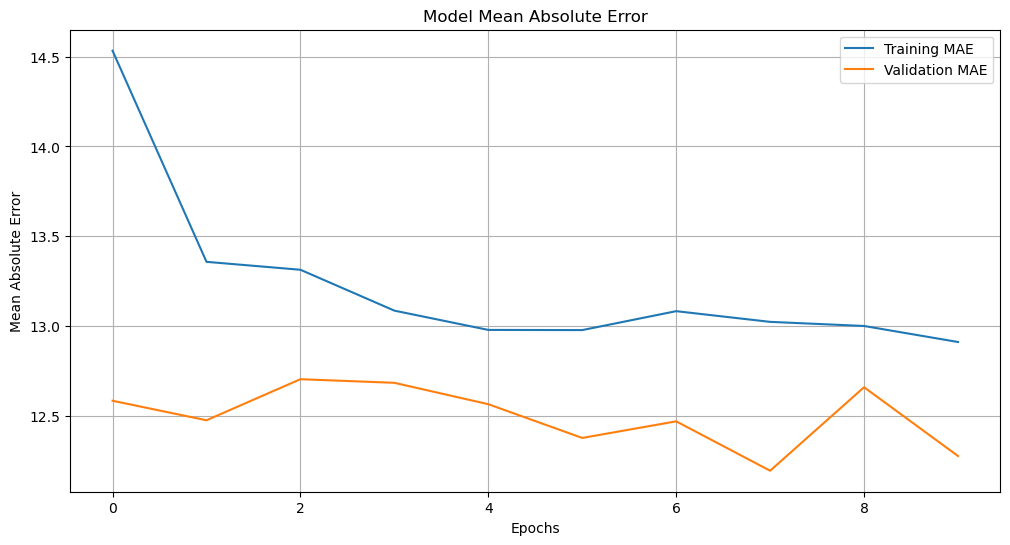

In [43]:
def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.figure(figsize=(12, 6))
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history.history)

In [52]:
# Save the model as a .keras file
model.save("resnet50_model_v12.keras")

In [51]:
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Training the model for 20 more epochs with all layers unfrozen

# Unfreeze the base model
for layer in base_model.layers:
    layer.trainable = True

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',       # Filepath to save the model
    monitor='val_loss',            # Metric to monitor (e.g., validation loss)
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model (weights + architecture)
    mode='min',                    # Save when 'val_loss' is minimized
    verbose=1                      # Print messages when saving
)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model with the checkpoint callback
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint_callback, tensorboard_callback]  # Add the callback here
)

Epoch 1/20


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 83.3860 - mae: 7.0395
Epoch 1: val_loss improved from inf to 24.12250, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 182s 982ms/step - loss: 83.3314 - mae: 7.0373 - val_loss: 24.1225 - val_mae: 3.8426
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - loss: 74.7065 - mae: 6.6442
Epoch 2: val_loss did not improve from 24.12250
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 984ms/step - loss: 74.6979 - mae: 6.6441 - val_loss: 38.7990 - val_mae: 4.8186
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - loss: 71.3685 - mae: 6.5394
Epoch 3: val_loss did not improve from 24.12250
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 689ms/step - loss: 71.3725 - mae: 6.5396 - val_loss: 31.1233 - val_mae: 4.6254
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - loss: 71.8532 - mae: 6.5797
Epoch 4: val_loss did not improve from 24.12250
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 584ms/step - loss: 71.8537 - mae: 6.5795 - val_loss: 26.7894 - val_mae: 3.9718

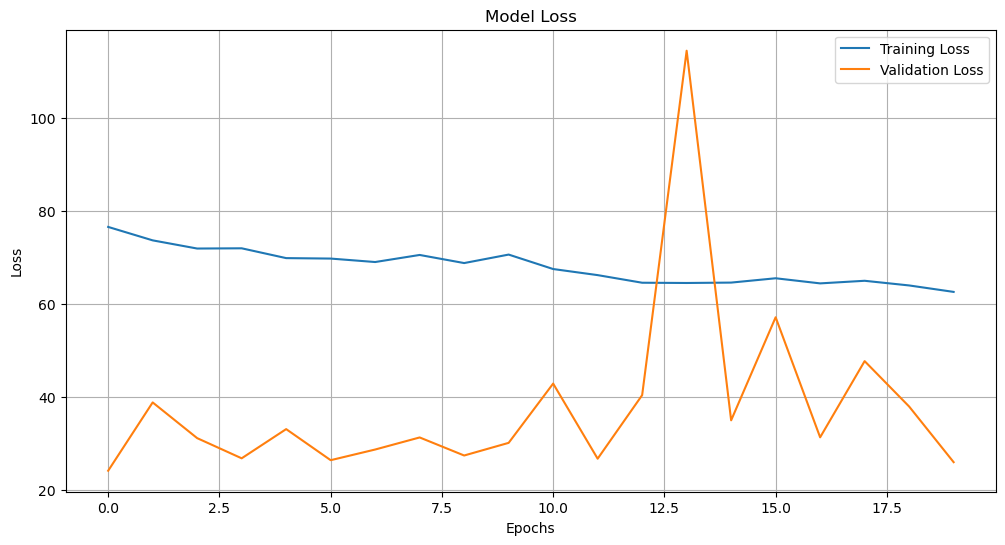

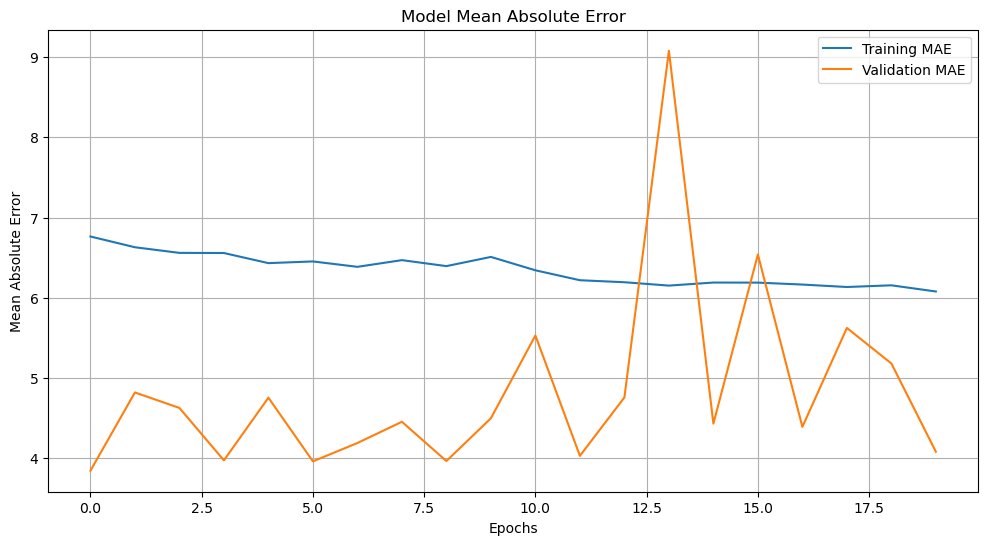

In [53]:
plot_history(history_fine_tune.history)

In [54]:
# Load the saved model
# model = tf.keras.models.load_model('resnet50_model_v5.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 27.0898 - mae: 4.1884
Test Loss: 25.96067237854004, Test MAE: 4.079159736633301


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[16.051775 29.669327 20.525682]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[[21.38463 26.65473 35.9091 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[19.873074 31.733618 19.756378]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[22.059832 19.577103 25.610233]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[ 4.307621  4.016416 36.074062]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[25.732737 35.440117 19.277664]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[24.782299 31.017113 17.743216]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[24.45889  32.925304  3.955005]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[31.722704   3.3847663 17.991976 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[25.422382 16.29033  39.228935]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[11.870848 24.604939 35.509335]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[11.443526  28.347975   3.0870168]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[22.57684  25.409782  5.24371 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[35.161625   1.175680

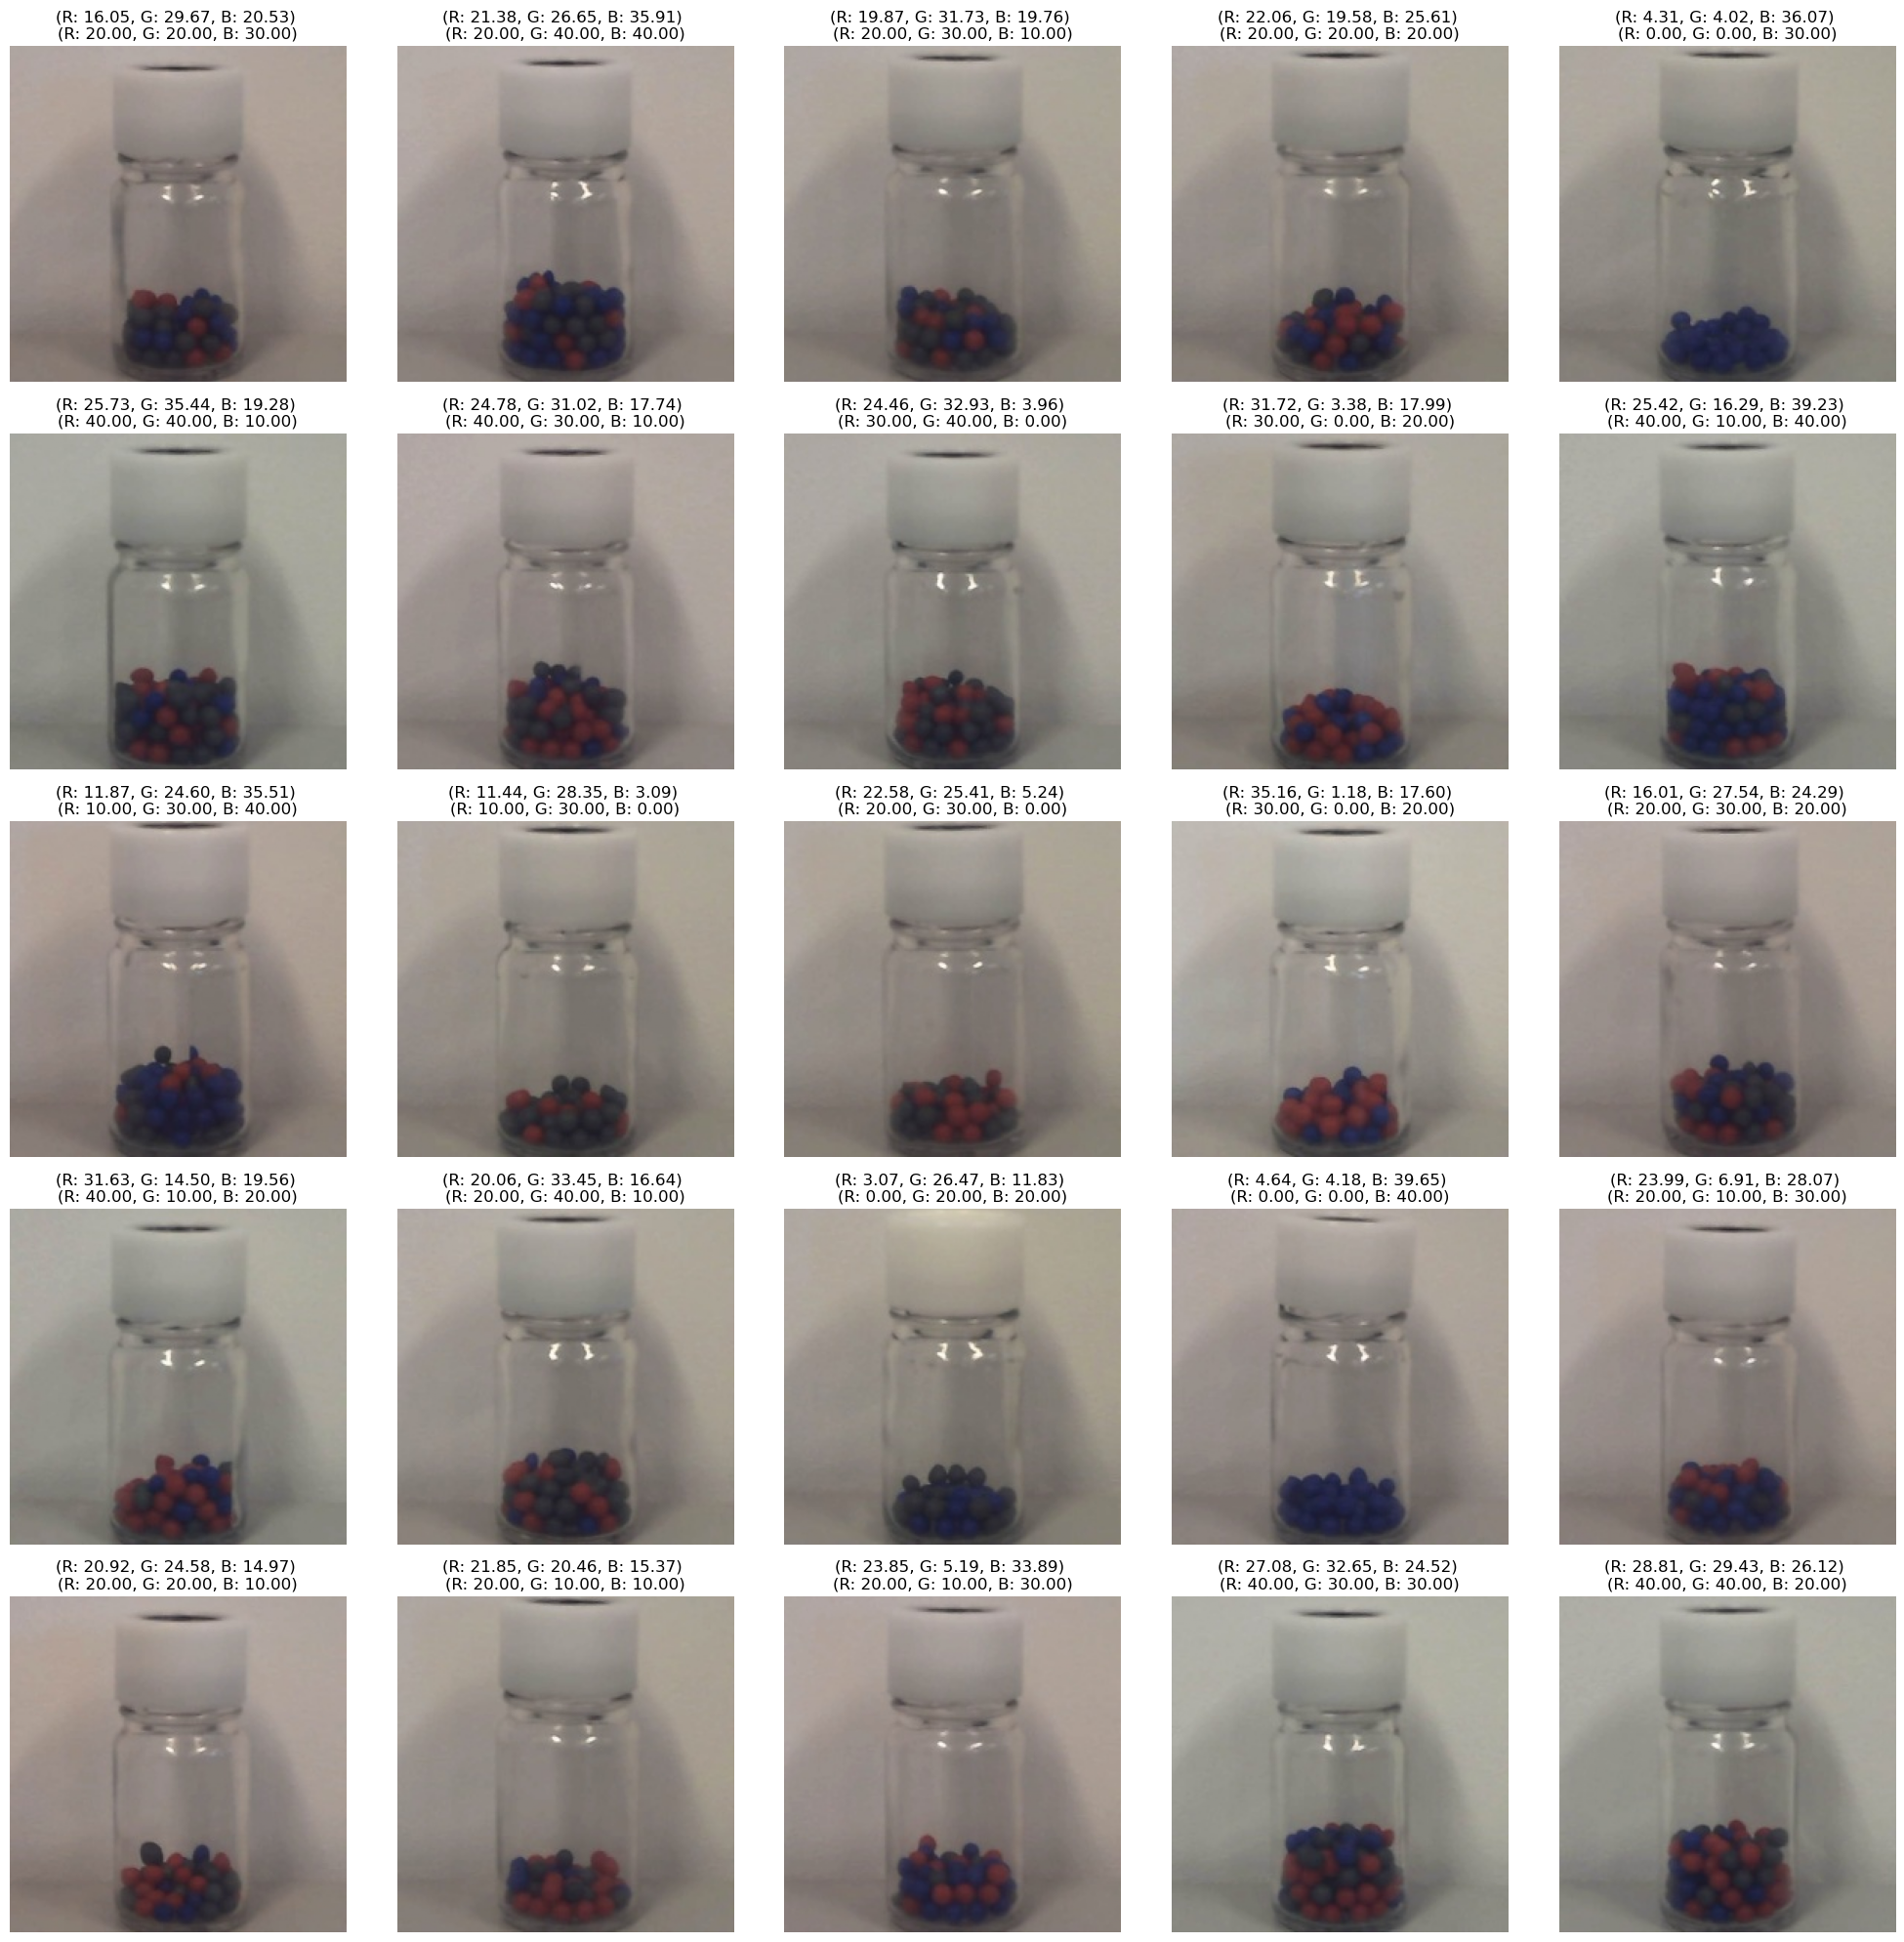

In [60]:
predictions = []

for img, label in zip(X_test[:25], y_test[:25]):
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(prediction)
    predictions.append((img, label, prediction[0]))

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image,label, prediction) in enumerate(predictions):
    axs[idx].imshow(image[0])
    axs[idx].set_title(f"(R: {prediction[0]:.2f}, G: {prediction[1]:.2f}, B: {prediction[2]:.2f}) \n(R: {label[0]:.2f}, G: {label[1]:.2f}, B: {label[2]:.2f})")    
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()